采用PyTorch搭建卷积神经网络(CNN)并进行以下孤立词的简单语音识别：
1. 打开后备箱
2. 关闭后备箱
3. 开后备箱
4. 关后备箱
@Vela 

运行前推荐选择“代码执行程序-更改运行时类型-硬件加速器-GPU”
@Vela 

In [25]:
!git clone https://github.com/Vela-Yang/Speech-Recognize-via-CNN.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%matplotlib inline

导入PyTorch相关的库

In [27]:
!pip install torchaudio
!pip install pydub
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


导入数据库

In [29]:
import os
from typing import Tuple, Optional, Union
from pathlib import Path

from torchaudio import load as AudioLoad
from torch.utils.data import Dataset
from torch import Tensor


FOLDER_IN_ARCHIVE = "MyDataset"
EXCEPT_FOLDER = "_background_noise_"

# 加载列表
def _load_list(root, *filenames):
    output = []
    for filename in filenames:
        filepath = os.path.join(root, filename)
        with open(filepath) as fileobj:
            output += [os.path.normpath(os.path.join(root, line.strip())) for line in fileobj]
    return output

# 加载语音
def load_item(filepath: str, path: str) -> Tuple[Tensor, int, str, str, int]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    # Load audio
    waveform, sample_rate = AudioLoad(filepath)
    return waveform, sample_rate, label

# 定义数据集类
class MyDataset(Dataset):

    # 初始化方法
    def __init__(self,
                 root: Union[str, Path],
                 folder_in_archive: str = FOLDER_IN_ARCHIVE,
                 subset: Optional[str] = None,
                 ) -> None:

        assert subset is None or subset in ["training", "validation", "testing"], (
            "When `subset` not None, it must take a value from "
            + "{'training', 'validation', 'testing'}."
        )

        root = os.fspath(root)

        self._path = os.path.join(root, folder_in_archive)


        if subset == "validation":
            self._walker = _load_list(self._path, "validation_list.txt")
        elif subset == "testing":
            self._walker = _load_list(self._path, "testing_list.txt")
        elif subset == "training":
            excludes = set(_load_list(self._path, "validation_list.txt", "testing_list.txt"))
            walker = sorted(str(p) for p in Path(self._path).glob('*/*.wav'))
            self._walker = [
                w for w in walker
                if EXCEPT_FOLDER not in w
                and os.path.normpath(w) not in excludes
            ]
        else:
            walker = sorted(str(p) for p in Path(self._path).glob('*/*.wav'))
            self._walker = [w for w in walker if EXCEPT_FOLDER not in w]

    # 定义得到样本方法
    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str, int]:
        fileid = self._walker[n]
        return load_item(fileid, self._path)


    def __len__(self) -> int:
        return len(self._walker)


建立数据集子集，包括训练集、测试集与有效集

In [30]:
import os


class SubsetSC(MyDataset):
    def __init__(self, subset: str = None):
        super().__init__("./Speech-Recognize-via-CNN/")

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath, encoding='utf8') as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label = train_set[0]

展示一个来自训练集的音频信息

Shape of waveform: torch.Size([1, 48160])
Sample rate of waveform: 16000


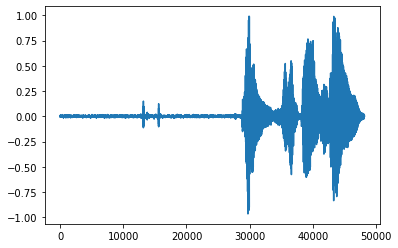

In [31]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

列出音频标签

In [32]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['关后备箱', '关闭后备箱', '开后备箱', '打开后备箱']

列举几个声音样本
这个是“打开后备箱”

In [33]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


这个是“关后备箱”

In [34]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

对音频信号重采样（统一采样率）
由于大家设备不同，导致录制的音频也不同。
同时，8000Hz完全可以胜任语音采样。
这里听一下重采样后的信号

tensor([[-0.0028, -0.0014, -0.0035,  ...,  0.0039,  0.0007,  0.0003]])


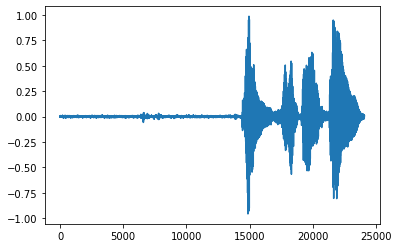

In [35]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)
print(transformed)
plt.plot(transformed.t().numpy())
ipd.Audio(transformed.numpy(), rate=8000)
#import librosa.display
#librosa.display.specshow(librosa.power_to_db(transformed.numpy(), ref = np.max), y_axis='mel', fmax=8000, x_axis='time')


使用音频文件的索引来对应其标签

In [36]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "打开后备箱"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

打开后备箱 --> tensor(3) --> 打开后备箱


将信号转换成张量，适应CNN模型的输入

In [37]:
def pad_sequence(batch):
    # 用填充0的方法让所有张量等维
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

神经网络定义
第一层为80点卷积层，在处理8000Hz音频时，帧长大约25ms。

In [38]:
class M3_CNN(nn.Module):
    def __init__(self, n_input=1, n_output=4, stride=4, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=120, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear( n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M3_CNN(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M3_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(120,), stride=(4,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=4, bias=True)
)
Number of parameters: 7236


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [40]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [41]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

开始模型训练

Train Epoch: 1 [0/254 (0%)]	Loss: 1.398651

Test Epoch: 1	Accuracy: 45/180 (25%)

Train Epoch: 2 [0/254 (0%)]	Loss: 1.380513

Test Epoch: 2	Accuracy: 45/180 (25%)

Train Epoch: 3 [0/254 (0%)]	Loss: 1.372026

Test Epoch: 3	Accuracy: 45/180 (25%)

Train Epoch: 4 [0/254 (0%)]	Loss: 1.360998

Test Epoch: 4	Accuracy: 45/180 (25%)

Train Epoch: 5 [0/254 (0%)]	Loss: 1.354375

Test Epoch: 5	Accuracy: 45/180 (25%)

Train Epoch: 6 [0/254 (0%)]	Loss: 1.344655

Test Epoch: 6	Accuracy: 45/180 (25%)

Train Epoch: 7 [0/254 (0%)]	Loss: 1.337602

Test Epoch: 7	Accuracy: 45/180 (25%)

Train Epoch: 8 [0/254 (0%)]	Loss: 1.330847

Test Epoch: 8	Accuracy: 45/180 (25%)

Train Epoch: 9 [0/254 (0%)]	Loss: 1.322232

Test Epoch: 9	Accuracy: 45/180 (25%)

Train Epoch: 10 [0/254 (0%)]	Loss: 1.312006

Test Epoch: 10	Accuracy: 45/180 (25%)

Train Epoch: 11 [0/254 (0%)]	Loss: 1.301507

Test Epoch: 11	Accuracy: 44/180 (24%)

Train Epoch: 12 [0/254 (0%)]	Loss: 1.292764

Test Epoch: 12	Accuracy: 45/180 (25%)

Train Epoc

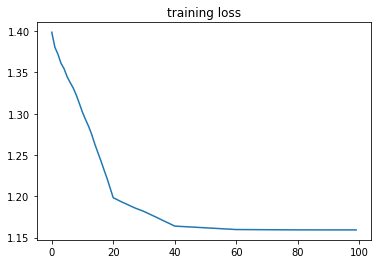

In [42]:
log_interval = 20
n_epoch = 100

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

根据输入计算其分类

In [43]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: 打开后备箱. Predicted: 打开后备箱.


以下是一个分类不成功的例子

In [44]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #22. Expected: 打开后备箱. Predicted: 关后备箱.


尝试

In [45]:
import sys
def record(seconds=3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
print(f"Predicted: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: 关闭后备箱.


Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


